In [3]:
import pickle
import torch
import numpy as np
import PIL.Image
#import logging
import os

In [4]:
import pickle
import torch
import numpy as np
import PIL.Image
#import logging
import os
print("old directory: ",os.getcwd())
os.chdir(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch')
print("new directory: ",os.getcwd())
# your trained network file 
from training.networks import Generator, Discriminator  # ensure the new repo is part of your python path
path = r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\network-tadne.pt.pkl"

old directory:  c:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch
new directory:  C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch


### Get Networks

In [7]:
mapping_kwargs  = {"num_layers":4,"layer_features":1024}   # Arguments for MappingNetwork.
synthesis_kwargs    = {"channel_base":(32<<10)*2,"channel_max":1024}

from pprint import pprint
with open(path, 'rb') as f:
    fs = pickle.load(f)
    G = fs['G_ema'].cpu()  # torch.nn.Module
    D = fs['D'].cpu()  # torch.nn.Module

# create a new network using the new defintion
G2 = Generator(
        z_dim = 1024,  # Input latent (Z) dimensionality.
        c_dim = 0,  # Conditioning label (C) dimensionality.
        w_dim = 1024,  # Intermediate latent (W) dimensionality.
        img_resolution = 512,  # Output resolution.
        img_channels = 3,
        mapping_kwargs=mapping_kwargs,
        synthesis_kwargs=synthesis_kwargs,

).cpu()

m_k = {"mbstd_group_size":32,"mbstd_num_channels":4}
D1 = Discriminator(
    c_dim=0,
    img_resolution=512,
    img_channels=3,
    channel_base=(16<<10)*2,
    epilogue_kwargs=m_k,
).cpu()


# update the weights to match your trained model
g_sd = G.state_dict()
g2_sd = G2.state_dict()
d_sd = D.state_dict()
d1_sd = D1.state_dict()

for k, _ in g2_sd.items():
    g2_sd[k] = g_sd[k]

for k, _ in d1_sd.items():
    d1_sd[k] = d_sd[k]

pprint(len(d1_sd.keys()))
pprint(d1_sd.keys())
D1.load_state_dict(d1_sd)
G2.load_state_dict(g2_sd)

z = torch.from_numpy(np.random.RandomState(0).randn(1, 1024).astype("float32"))

G3 = G2.mapping
G3.eval()

G4 = G2.synthesis
G4.eval()

D1.eval();

73
odict_keys(['b512.resample_filter', 'b512.fromrgb.weight', 'b512.fromrgb.bias', 'b512.fromrgb.resample_filter', 'b512.conv0.weight', 'b512.conv0.bias', 'b512.conv0.resample_filter', 'b512.conv1.weight', 'b512.conv1.bias', 'b512.conv1.resample_filter', 'b512.skip.weight', 'b512.skip.resample_filter', 'b256.resample_filter', 'b256.conv0.weight', 'b256.conv0.bias', 'b256.conv0.resample_filter', 'b256.conv1.weight', 'b256.conv1.bias', 'b256.conv1.resample_filter', 'b256.skip.weight', 'b256.skip.resample_filter', 'b128.resample_filter', 'b128.conv0.weight', 'b128.conv0.bias', 'b128.conv0.resample_filter', 'b128.conv1.weight', 'b128.conv1.bias', 'b128.conv1.resample_filter', 'b128.skip.weight', 'b128.skip.resample_filter', 'b64.resample_filter', 'b64.conv0.weight', 'b64.conv0.bias', 'b64.conv0.resample_filter', 'b64.conv1.weight', 'b64.conv1.bias', 'b64.conv1.resample_filter', 'b64.skip.weight', 'b64.skip.resample_filter', 'b32.resample_filter', 'b32.conv0.weight', 'b32.conv0.bias', 'b32.

### Torch JIT Tracing for Onnx

In [286]:
#Trace G_ema, D
#G_ema Mapping
G3_scripted = torch.jit.trace(G3, (torch.randn((1, 1024), dtype=torch.float32))) # c -> None is now Default Argument see networks.py
#G_ema Synthesis
G4_scripted = torch.jit.trace(G4, (torch.randn((1, 16, 1024), dtype=torch.float32)))
#D
D1_scripted = torch.jit.trace(D1, (torch.randn((1, 3, 512, 512), dtype=torch.float32)));


c:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\training\networks.py:630: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  c = C // F
c:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\training\networks.py:630: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To ke

In [11]:
def create_im(tensor_arr,files = None):
    img = (tensor_arr + 1) * 255 / 2  # [-1.0, 1.0] -> [0.0, 255.0]
    img = img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[0]  # NCWH => NWHC
    if files != None:
        PIL.Image.fromarray(img, 'RGB').save(files)
    return PIL.Image.fromarray(img, 'RGB')

In [288]:
print(z)

tensor([[ 1.7641,  0.4002,  0.9787,  ...,  0.7010, -0.4175, -1.0975]])


In [289]:
with torch.no_grad():
    a = G3_scripted.forward(z)
    latent_w_avg = torch.zeros(1024,)
    w_avg = latent_w_avg.lerp(a,0.5)
    a = G4_scripted.forward(w_avg)
    b = D1_scripted.forward(a)
print(a,b)

tensor([[[[-0.1053, -0.1546, -0.1961,  ..., -0.2618, -0.2335, -0.1853],
          [-0.1443, -0.2175, -0.2419,  ..., -0.3116, -0.3127, -0.2673],
          [-0.1929, -0.2474, -0.2736,  ..., -0.3505, -0.3384, -0.2980],
          ...,
          [ 0.8938,  0.8821,  0.8867,  ...,  0.8760,  0.8721,  0.8929],
          [ 0.8881,  0.8815,  0.8842,  ...,  0.8655,  0.8686,  0.8694],
          [ 0.8418,  0.9022,  0.9056,  ...,  0.8906,  0.8930,  0.8350]],

         [[ 0.3488,  0.4549,  0.4625,  ...,  0.3779,  0.3616,  0.2035],
          [ 0.4590,  0.4714,  0.4610,  ...,  0.3813,  0.3822,  0.3402],
          [ 0.4765,  0.4709,  0.4602,  ...,  0.3584,  0.3785,  0.3616],
          ...,
          [ 1.0301,  0.9871,  0.9873,  ...,  0.9681,  0.9672,  1.0051],
          [ 1.0276,  0.9879,  0.9805,  ...,  0.9716,  0.9760,  0.9959],
          [ 0.9281,  1.0125,  1.0135,  ...,  0.9972,  1.0032,  0.9181]],

         [[ 0.3642,  0.4403,  0.4404,  ...,  0.3929,  0.3947,  0.2189],
          [ 0.4459,  0.4536,  

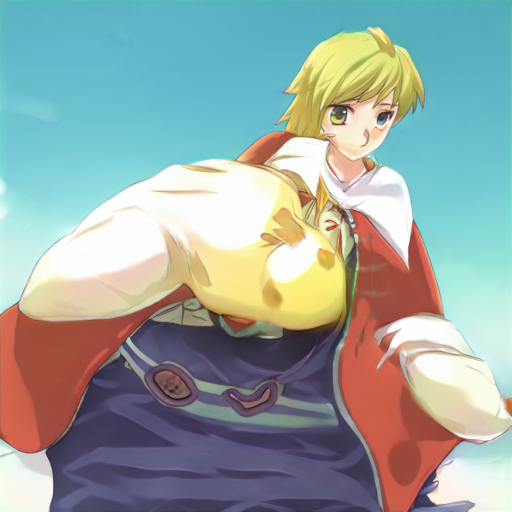

In [290]:
#create_im(a,"bangla.jpg")
display(create_im(a))

### Torch Onnx Export

In [291]:
torch.onnx.export(G3_scripted, (torch.randn((1, 1024), dtype=torch.float32)) , "modelmap.onnx", verbose=True, input_names=["rand_array"], output_names=["latent_w"], opset_version=10)
torch.onnx.export(G4_scripted, (torch.randn((1, 16, 1024), dtype=torch.float32)) , "modelsynthnew.onnx", verbose=True, input_names=["latent_w_synth"], output_names=["image"], opset_version=10)
torch.onnx.export(D1_scripted, (torch.randn((1, 3, 512, 512), dtype=torch.float32)) , "D.onnx", verbose=True, input_names=["NCHW_image"], output_names=["out"], opset_version=10);

c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\torch\onnx\utils.py:461: UserWarning: no signature found for <torch.ScriptMethod object at 0x000002100D816B88>, skipping _decide_input_format
  warnings.warn("%s, skipping _decide_input_format" % e)
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\torch\onnx\utils.py:461: UserWarning: no signature found for <torch.ScriptMethod object at 0x000002100D816B28>, skipping _decide_input_format
  warnings.warn("%s, skipping _decide_input_format" % e)
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\torch\onnx\utils.py:461: UserWarning: no signature found for <torch.ScriptMethod object at 0x000002100D816948>, skipping _decide_input_format
  warnings.warn("%s, skipping _decide_input_format" % e)


In [5]:
from onnxmltools.utils import load_model, save_model
import onnxruntime as ort
import onnx
import numpy as np
modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelmap.onnx"
ort_sess = ort.InferenceSession(modelPath,providers=['CPUExecutionProvider'])
z = np.random.RandomState(0).randn(1, 1024).astype("float32")
outputs = ort_sess.run(None, {'rand_array': z})
print(outputs)

[array([[[-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        ...,
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ]]], dtype=float32)]


In [6]:
import torch
def truncation(x, psi,cutoff):
    latent_w_avg = torch.zeros(1024,)
    if cutoff is None:
        return latent_w_avg.lerp(torch.from_numpy(x),psi).detach().cpu().numpy() #w_avg
    else:
        x[:, :cutoff] = latent_w_avg.lerp(x[:, :cutoff], psi).detach().cpu().numpy()
        return x
w_avg = truncation(outputs[0],psi=0.5,cutoff=None)

In [9]:
sess_options = ort.SessionOptions()
# Set graph optimization level
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
# To enable model serialization after graph optimization set this
#sess_options.optimized_model_filepath = r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx"

modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx"
ort_sess = ort.InferenceSession(modelPath,sess_options=sess_options,providers=['CPUExecutionProvider'])
output_syn = ort_sess.run(None, {'latent_w': w_avg})
print(output_syn)

[array([[[[-0.10527831, -0.15455154, -0.19612679, ..., -0.26180026,
          -0.2335085 , -0.18529367],
         [-0.14425424, -0.21745792, -0.24191701, ..., -0.3116421 ,
          -0.31269667, -0.26726076],
         [-0.19287032, -0.2473495 , -0.27360964, ..., -0.35053194,
          -0.33837056, -0.29798558],
         ...,
         [ 0.8938168 ,  0.88213664,  0.88665044, ...,  0.87603325,
           0.87206805,  0.8928669 ],
         [ 0.88807476,  0.8815056 ,  0.88424844, ...,  0.8654538 ,
           0.86856365,  0.8693894 ],
         [ 0.84176373,  0.90221214,  0.9056127 , ...,  0.89064777,
           0.89300376,  0.8349999 ]],

        [[ 0.348768  ,  0.45493323,  0.46247175, ...,  0.37793398,
           0.3616141 ,  0.20345318],
         [ 0.4590008 ,  0.4714147 ,  0.46095455, ...,  0.3813395 ,
           0.38223797,  0.34017903],
         [ 0.47648877,  0.47090912,  0.46020657, ...,  0.35837984,
           0.3784836 ,  0.36161298],
         ...,
         [ 1.0300992 ,  0.9870949

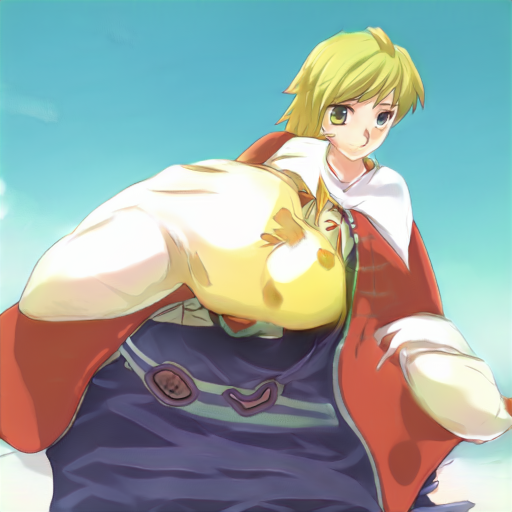

In [12]:
create_im(torch.from_numpy(output_syn[0]),"banglas.jpg")

In [14]:
modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\D.onnx"
ort_sess = ort.InferenceSession(modelPath,providers=['CPUExecutionProvider'])
output_D = ort_sess.run(None, {'NCHW_image': output_syn[0]})
print(output_D)

[array([[-3.6931138]], dtype=float32)]


### Onnx Simplifier

In [ ]:
!python -m onnxsim  "C:\Users\Aravind\Desktop\stylegan2-ada-pytorch-main\stylegan2-ada-pytorch-main\modelsynth.onnx" "C:\Users\Aravind\Desktop\stylegan2-ada-pytorch-main\stylegan2-ada-pytorch-main\modelsynthsim.onnx" --input-shape="latent_w:1,16,1024"

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Finish! Here is the difference:
┌─────────────────┬────────────────┬──────────────────┐
│                 │ Original Model │ Simplified Model │
├─────────────────┼────────────────┼──────────────────┤
│ Add             │ 60             │ 60               │
│ Cast            │ 39             │ 0                │
│ Constant        │ 245            │ 0                │
│ ConstantOfShape │ 15             │ 0                │
│ Conv            │ 30             │ 30               │
│ ConvTranspose   │ 7              │ 7                │
│ Div             │ 15             │ 15               │
│ Expand          │ 15             │ 0                │
│ Gemm            │ 23             │ 23               │
│ Identity        │ 125            │ 0                │
│ LeakyRelu       │

In [ ]:
!python -m onnxsim  "C:\Users\Aravind\Desktop\stylegan2-ada-pytorch-main\stylegan2-ada-pytorch-main\modelmap.onnx" "C:\Users\Aravind\Desktop\stylegan2-ada-pytorch-main\stylegan2-ada-pytorch-main\modelmapsim.onnx" --input-shape="rand_array:1,1024"

### TADNE Editing

In [ ]:
# %cd "/content"
# !wget  -O /content/tadne-directions.zip https://www.thisponydoesnotexist.net/tadne-directions.zip
# gdown.download('https://drive.google.com/uc?id=1x9cD_MV3UVboqnlpq9ZPWQ-kvFzxOGaz', 'deepdanbooru_dirs.pkl', quiet=False)
# %cd "/content"
# %mkdir directions
# %cd directions
# !unzip /content/tadne-directions.zip
# !rm /content/directions/StyleGAN2-Light_direction-ffhq-ipca-w-style-comp15-range8-9.pkl

In [2]:
import pickle
import numpy as np
deepdanbooru_dirs = pickle.load(open(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\deepdanbooru_dirs.pkl", 'rb'))
named_directions = {}
latent_dirs = []
starts = []
ends = []

comp = 0
for tag, vec in deepdanbooru_dirs.items():
    print(tag)
    for layers in [(0, 6), (6, 12), (12, 16)]:
        print(layers[0], layers[1])
        name = tag + "-" + str(layers[0]) + "-" + str(layers[1])
        named_directions[f'{name}'] = [comp, int(layers[0]), int(layers[1]), f'{name}']
    latent_dirs.append(np.matrix(vec[0]))
    comp = comp + 1
    #if comp > 50:
    #    break
#named_directions

1boy
0 6
6 12
12 16
1girl
0 6
6 12
12 16
2boys
0 6
6 12
12 16
2girls
0 6
6 12
12 16
3girls
0 6
6 12
12 16
:d
0 6
6 12
12 16
^_^
0 6
6 12
12 16
ahoge
0 6
6 12
12 16
alternate_costume
0 6
6 12
12 16
animal_ears
0 6
6 12
12 16
apron
0 6
6 12
12 16
aqua_eyes
0 6
6 12
12 16
aqua_hair
0 6
6 12
12 16
armor
0 6
6 12
12 16
armpits
0 6
6 12
12 16
arms_behind_back
0 6
6 12
12 16
arms_up
0 6
6 12
12 16
ass
0 6
6 12
12 16
bag
0 6
6 12
12 16
bandages
0 6
6 12
12 16
bangs
0 6
6 12
12 16
bare_shoulders
0 6
6 12
12 16
barefoot
0 6
6 12
12 16
belt
0 6
6 12
12 16
bikini
0 6
6 12
12 16
black_background
0 6
6 12
12 16
black_dress
0 6
6 12
12 16
black_eyes
0 6
6 12
12 16
black_hair
0 6
6 12
12 16
black_legwear
0 6
6 12
12 16
black_skirt
0 6
6 12
12 16
blonde_hair
0 6
6 12
12 16
blue_background
0 6
6 12
12 16
blue_dress
0 6
6 12
12 16
blue_eyes
0 6
6 12
12 16
blue_hair
0 6
6 12
12 16
blue_skirt
0 6
6 12
12 16
blue_sky
0 6
6 12
12 16
blue_theme
0 6
6 12
12 16
blunt_bangs
0 6
6 12
12 16
blurry
0 6
6 12
12 16
b

In [28]:
for items in named_directions.items():
    print(items)

('1boy-0-6', [0, 0, 6, '1boy-0-6'])
('1boy-6-12', [0, 6, 12, '1boy-6-12'])
('1boy-12-16', [0, 12, 16, '1boy-12-16'])
('1girl-0-6', [1, 0, 6, '1girl-0-6'])
('1girl-6-12', [1, 6, 12, '1girl-6-12'])
('1girl-12-16', [1, 12, 16, '1girl-12-16'])
('2boys-0-6', [2, 0, 6, '2boys-0-6'])
('2boys-6-12', [2, 6, 12, '2boys-6-12'])
('2boys-12-16', [2, 12, 16, '2boys-12-16'])
('2girls-0-6', [3, 0, 6, '2girls-0-6'])
('2girls-6-12', [3, 6, 12, '2girls-6-12'])
('2girls-12-16', [3, 12, 16, '2girls-12-16'])
('3girls-0-6', [4, 0, 6, '3girls-0-6'])
('3girls-6-12', [4, 6, 12, '3girls-6-12'])
('3girls-12-16', [4, 12, 16, '3girls-12-16'])
(':d-0-6', [5, 0, 6, ':d-0-6'])
(':d-6-12', [5, 6, 12, ':d-6-12'])
(':d-12-16', [5, 12, 16, ':d-12-16'])
('^_^-0-6', [6, 0, 6, '^_^-0-6'])
('^_^-6-12', [6, 6, 12, '^_^-6-12'])
('^_^-12-16', [6, 12, 16, '^_^-12-16'])
('ahoge-0-6', [7, 0, 6, 'ahoge-0-6'])
('ahoge-6-12', [7, 6, 12, 'ahoge-6-12'])
('ahoge-12-16', [7, 12, 16, 'ahoge-12-16'])
('alternate_costume-0-6', [8, 0, 6, 'alt

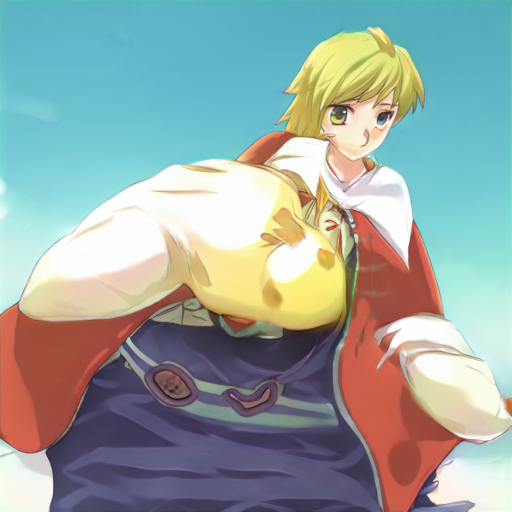

In [ ]:
def normalize(v):
    norm=np.linalg.norm(v, ord=2)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm * len(v)

n_sample = 1
inputSize = 1024
input_size = 1024
truncation = 0.5
#seed = 26225
#seed = 93940
seed = 0 
scale = 1
latent_avg = torch.zeros(1024,)

z = torch.from_numpy(np.random.RandomState(seed).randn(n_sample, inputSize).astype("float32"))

with torch.no_grad():
    all_W = G3_scripted.forward(z)

for i, tag in enumerate(named_directions):
    values = named_directions[tag]
    value = 0.0
    string = "bikini-0-6"
    if string in values:
        #value = 5.9
        value = 0
    # elif 'breasts-0-6' in values:
    #     value = 1.8
    # elif 'breasts-6-12' in values:
    #     value = 2.6
    start_l = named_directions[tag][1]
    end_l = min(16, named_directions[tag][2])
    direction_l = normalize(latent_dirs[named_directions[tag][0]])

    for l in range(start_l, end_l):
        #old_W[0][l] = all_W[0][l] + direction_l * value * scale * mask
        #new_W[0][l] = new_W[0][l] + (scale * direction_l * value) * 0.45 
        #new_W[0][l] = new_W[0][l] + new_W[0][l] * newmask
        #new_W[0][l] = new_W[0][l]
        all_W[0][l] = all_W[0][l] + direction_l * value * scale
    
    #new_W = new_W.float()

if truncation != 1:
    w_avg = latent_avg
    all_W = w_avg + (all_W - w_avg) * truncation # [minibatch, layer, component]

with torch.no_grad():
    img = G4.forward(all_W)

create_im(img)

### Projection StyleGAN2-ADA

In [ ]:
import copy
import os
from time import perf_counter

import click
import imageio
import numpy as np
import PIL.Image
from PIL import ImageFilter
import torch
import torch.nn.functional as F

import dnnlib
import legacy

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

def score_images(G, model, text, latents, device, label_class = 0, batch_size = 8, open_clip = False):
  scores = []
  all_images = []
  for i in range(latents.shape[0]//batch_size):
    images = G.synthesis(torch.tensor(latents[i*batch_size:(i+1)*batch_size,:,:], dtype=torch.float32, device=device), noise_mode='const')
    with torch.no_grad():
        image_input = (torch.clamp(images, -1, 1) + 1) * 0.5
        image_input = F.interpolate(image_input, size=(256, 256), mode='area')
        image_input = image_input[:, :, 16:240, 16:240] # 256 -> 224, center crop
        image_input -= image_mean[None, :, None, None]
        image_input /= image_std[None, :, None, None]
        if open_clip:
            image_f, text_f, _ = model(image_input, text)
            score = image_f @ text_f.T
        else:
            score = model(image_input, text)[0]
        scores.append(score.cpu().numpy())
        all_images.append(images.cpu().numpy())

  scores = np.array(scores)
  scores = scores.reshape(-1, *scores.shape[2:]).squeeze()
  scores = 1 - scores / np.linalg.norm(scores)
  all_images = np.array(all_images)
  all_images = all_images.reshape(-1, *all_images.shape[2:])
  return scores, all_images

def project(
    G,
    target_image: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    target_text,
    *,
    num_steps                  = 300,
    w_avg_samples              = 8192,
    initial_learning_rate      = 0.02,
    initial_latent             = None,
    initial_noise_factor       = 0.8, #0.01
    lr_rampdown_length         = 0.10,
    lr_rampup_length           = 0.5,
    noise_ramp_length          = 0.75,
    latent_range               = 2.0,
    max_noise                  = 0.5,
    min_threshold              = 0.6,
    use_vgg                    = True,
    use_clip                   = True,
    use_pixel                  = True,
    use_penalty                = True,
    use_center                 = True,
    regularize_noise_weight    = 1e5,
    kmeans                     = True,
    kmeans_clusters            = 64,
    verbose                    = False,
    device: torch.device       = "cuda",
    clippy                     = "",
    rs                         = 69,
):
    if target_image is not None:
        assert target_image.shape == (G.img_channels, G.img_resolution, G.img_resolution)
    else:
        use_vgg = False
        use_pixel = False

    # reduce errors unless using clip
    print('clippy',clippy)
    if use_clip:
        open_clip = False
        if clippy == "": 
            open_clip = True
            print('yaya')
            if open_clip: 
                import open_clip as clip
                
        else: import clip

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(rs).randn(w_avg_samples, G.z_dim)
    labels = None
    if (G.mapping.c_dim):
        labels = torch.from_numpy(0.5*np.random.RandomState(123).randn(w_avg_samples, G.mapping.c_dim)).to(device)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), labels)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)                 # [N, L, C]
    w_samples_1d = w_samples[:, :1, :].astype(np.float32)

    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, L, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    kmeans_latents = None
    if initial_latent is not None:
        w_avg = initial_latent
    else:
        if kmeans and use_clip and target_text is not None:
            from kmeans_pytorch import kmeans
            # data
            data_size, dims, num_clusters = w_avg_samples, G.z_dim, kmeans_clusters
            x = w_samples_1d
            x = torch.from_numpy(x)

            # kmeans
            logprint(f'Performing kmeans clustering using {w_avg_samples} latents into {kmeans_clusters} clusters...')
            cluster_ids_x, cluster_centers = kmeans(
                X=x, num_clusters=num_clusters, distance='euclidean', device=device
            )
            #logprint(f'\nGenerating images from kmeans latents...')
            kmeans_latents = torch.tensor(cluster_centers, dtype=torch.float32, device=device, requires_grad=True)
            #kmeans_latents = cluster_centers.clone().detach().requires_grad_(True).to(device)

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    if use_vgg:
        url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
        with dnnlib.util.open_url(url) as f:
            vgg16 = torch.jit.load(f).eval().to(device)

    # Load CLIP
    if use_clip:
        if open_clip:
            model, _, preprocess = clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16')
        else:
            model, preprocess = clip.load("ViT-B/32", device=device)
        model.to(device=device)

    # Features for target image.
    if target_image is not None:
        target_images = target_image.unsqueeze(0).to(device).to(torch.float32)
        small_target = F.interpolate(target_images, size=(64, 64), mode='area')
        if use_center:
            center_target = F.interpolate(target_images, size=(448, 448), mode='area')[:, :, 112:336, 112:336]
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
        target_images = target_images[:, :, 16:240, 16:240] # 256 -> 224, center crop

    if use_vgg:
        vgg_target_features = vgg16(target_images, resize_images=False, return_lpips=True)
        if use_center:
            vgg_target_center = vgg16(center_target, resize_images=False, return_lpips=True)

    if use_clip:
        if target_image is not None:
            with torch.no_grad():
                clip_target_features = model.encode_image(((target_images / 255.0) - image_mean[None, :, None, None]) / image_std[None, :, None, None]).float().to(device)
                if use_center:
                    clip_target_center = model.encode_image(((center_target / 255.0) - image_mean[None, :, None, None]) / image_std[None, :, None, None]).float().to(device)

    if kmeans_latents is not None and use_clip and target_text is not None:
        scores, kmeans_images = score_images(G, model, target_text, kmeans_latents.repeat([1, G.mapping.num_ws, 1]), device=device, open_clip=open_clip)
        #TODO
        print(scores)
        try:print(scores.shape)
        except:print(type(scores))
        ind = np.argpartition(scores, 4)[:4]
        w_avg = torch.median(kmeans_latents[ind],dim=0,keepdim=True)[0].repeat([1, G.mapping.num_ws, 1])

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_avg_tensor = w_opt.clone()
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.AdamW([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = max_noise * w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(torch.clamp(ws,-latent_range,latent_range), noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. CLIP was built for 224x224 images.
        synth_images = (torch.clamp(synth_images, -1, 1) + 1) * (255/2)
        small_synth = F.interpolate(synth_images, size=(64, 64), mode='area')
        if use_center:
            center_synth = F.interpolate(synth_images, size=(448, 448), mode='area')[:, :, 112:336, 112:336]
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_images = synth_images[:, :, 16:240, 16:240] # 256 -> 224, center crop

        dist = 0

        if use_vgg:
            vgg_synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
            vgg_dist =  (vgg_target_features - vgg_synth_features).square().sum()
            if use_center:
                vgg_synth_center = vgg16(center_synth, resize_images=False, return_lpips=True)
                vgg_dist += (vgg_target_center - vgg_synth_center).square().sum()
            vgg_dist *= 6
            dist += F.relu(vgg_dist*vgg_dist - min_threshold)

        if use_clip:
            clip_synth_image = ((synth_images / 255.0) - image_mean[None, :, None, None]) / image_std[None, :, None, None]
            clip_synth_features = model.encode_image(clip_synth_image).float()
            adj_center = 2.0

            if use_center:
                clip_cynth_center_image = ((center_synth / 255.0) - image_mean[None, :, None, None]) / image_std[None, :, None, None]
                adj_center = 1.0
                clip_synth_center = model.encode_image(clip_cynth_center_image).float()

            if target_image is not None:
                clip_dist =  (clip_target_features - clip_synth_features).square().sum()
                if use_center:
                    clip_dist += (clip_target_center - clip_synth_center).square().sum()
                dist += F.relu(0.5 + adj_center*clip_dist - min_threshold)

            if target_text is not None:
                clip_text = 1 - model(clip_synth_image, target_text)[0].sum() / 100
                if use_center:
                    clip_text += 1 - model(clip_cynth_center_image, target_text)[0].sum() / 100
                dist += 2*F.relu(adj_center*clip_text*clip_text - min_threshold / adj_center)

        if use_pixel:
            pixel_dist =  (target_images - synth_images).abs().sum() / 2000000.0
            if use_center:
                pixel_dist += (center_target - center_synth).abs().sum() / 2000000.0
            pixel_dist += (small_target - small_synth).square().sum() / 800000.0
            pixel_dist /= 4
            dist += F.relu(lr_ramp * pixel_dist - min_threshold)

        if use_penalty:
            l1_penalty = (w_opt - w_avg_tensor).abs().sum() / 5000.0
            dist += F.relu(lr_ramp * l1_penalty - min_threshold)

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        #print(vgg_dist, clip_dist, pixel_dist, l1_penalty, reg_loss * regularize_noise_weight)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
        with torch.no_grad():
            torch.clamp(w_opt,-latent_range,latent_range,out=w_opt)
        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]
        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out


In [ ]:
import open_clip
def run_projection(
    network_pkl: str,
    target_fname: str,
    target_text: str = None,
    initial_latent: str = None,
    outdir: str = "out",
    save_video: bool = False,
    seed: int = 0,
    lr: float = 0.1,
    num_steps: int = 300,
    use_vgg: bool = True,
    use_clip: bool = True,
    use_pixel: bool = True,
    use_penalty: bool= True,
    use_center: bool = True,
    use_kmeans: bool = True,
    device: str = 'cuda',
    clippy: str = "",
):
    """Project given image to the latent space of pretrained network pickle.
    Examples:
    \b
    python projector.py --outdir=out --target=~/mytargetimg.png \\
        --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device(device)
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    # Load target image.
    target_image = None
    if target_fname:
        target_pil = PIL.Image.open(target_fname).convert('RGB').filter(ImageFilter.SHARPEN)

        w, h = target_pil.size
        s = min(w, h)
        target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
        target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
        target_uint8 = np.array(target_pil, dtype=np.uint8)
        target_image = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

    if target_text:
        try: target_text = torch.cat([open_clip.tokenize(target_text)]).to(device)
        except: target_text = torch.cat([clip.tokenize(target_text)]).to(device)

    if initial_latent is not None:
        initial_latent = np.load(initial_latent)
        initial_latent = initial_latent[initial_latent.files[0]]

    # Optimize projection.
    start_time = perf_counter()
    projected_w_steps = project(
        G,
        target_image=target_image,
        target_text=target_text,
        initial_latent=initial_latent,
        initial_learning_rate=lr,
        num_steps=num_steps,
        use_vgg=use_vgg,
        use_clip=use_clip,
        use_pixel=use_pixel,
        use_penalty=use_penalty,
        use_center=use_center,
        kmeans=use_kmeans,
        device=device,
        verbose=True,
        clippy = clippy,
        rs = seed,
    )
    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

    os.makedirs(outdir, exist_ok=True)
    # Save final projected frame and W vector.
    if target_fname:
        target_pil.save(f'{outdir}/target.png')
    projected_w = projected_w_steps[-1]
    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/proj.png')
    np.savez(f'{outdir}/projected_w.npz', w=projected_w.unsqueeze(0).cpu().numpy())

    # Render debug output: optional video and projected image and W vector.
    if save_video:
        video = imageio.get_writer(f'{outdir}/proj.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
        print (f'Saving optimization progress video "{outdir}/proj.mp4"')
        for projected_w in projected_w_steps:
            synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
            if target_fname:
                video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
            else:
                video.append_data(synth_image)
        video.close()

In [ ]:
run_projection(seed=0,network_pkl=r"C:\Users\Aravind\Desktop\FYP Anime GAN Implementations\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\network-tadne.pt.pkl",
                target_fname=r"C:\Users\Aravind\Desktop\upscale\is3pjxhqo5091.jpg")

In [ ]:
torch.cuda.empty_cache()
run_projection(seed=69,network_pkl=r"C:\Users\Aravind\Desktop\FYP Anime GAN Implementations\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\network-tadne.pt.pkl",
                target_fname=None,target_text="A girl with huge boobs",clippy="")

Loading networks from "C:\Users\Aravind\Desktop\FYP Anime GAN Implementations\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\network-tadne.pt.pkl"...
clippy 
yaya
Computing W midpoint and stddev using 8192 samples...
Performing kmeans clustering using 8192 latents into 64 clusters...
running k-means on cuda..


[running kmeans]: 34it [00:26,  1.31it/s, center_shift=0.000000, iteration=34, tol=0.000100]      
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\ipykernel_launcher.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\ipykernel_launcher

[0.86329496 0.90879416 0.84038204 0.8636329  0.8873032  0.8628574
 0.853283   0.87400556 0.8746831  0.8600323  0.87909716 0.8729982
 0.8588391  0.86927915 0.8267963  0.8827009  0.8455008  0.86890745
 0.86411583 0.87151134 0.87086266 0.83666927 0.8820653  0.88567513
 0.8800774  0.8908236  0.8827828  0.8624148  0.87742597 0.9077059
 0.86729914 0.8750098  0.89204264 0.86527926 0.8892422  0.88978326
 0.9052627  0.89086413 0.87949735 0.89079314 0.8755441  0.8635975
 0.8778912  0.8929826  0.8834172  0.8590958  0.8863714  0.8711363
 0.8763296  0.8814665  0.87451434 0.8813009  0.8575322  0.88488555
 0.90582263 0.8853306  0.8756062  0.8848964  0.91110057 0.91774994
 0.86001825 0.87168384 0.88182163 0.8660191 ]
(64,)


c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


step    1/300: dist 6.79 loss 14628.92
step    2/300: dist 6.80 loss 11442.29
step    3/300: dist 6.79 loss 11332.13
step    4/300: dist 6.80 loss 11115.55
step    5/300: dist 6.89 loss 10800.93
step    6/300: dist 6.86 loss 10399.02
step    7/300: dist 6.87 loss 9922.83
step    8/300: dist 6.79 loss 9387.21
step    9/300: dist 6.73 loss 8807.93
step   10/300: dist 6.82 loss 8199.31
step   11/300: dist 6.74 loss 7572.69
step   12/300: dist 6.79 loss 6937.95
step   13/300: dist 6.75 loss 6303.37
step   14/300: dist 6.81 loss 5677.28
step   15/300: dist 6.80 loss 5068.99
step   16/300: dist 6.73 loss 4490.61
step   17/300: dist 6.82 loss 3954.83
step   18/300: dist 6.79 loss 3471.02
step   19/300: dist 6.77 loss 3043.02
step   20/300: dist 6.83 loss 2667.71
step   21/300: dist 6.83 loss 2336.69
step   22/300: dist 6.82 loss 2042.54
step   23/300: dist 6.78 loss 1781.18
step   24/300: dist 6.82 loss 1545.98
step   25/300: dist 6.81 loss 1330.02
step   26/300: dist 6.88 loss 1131.53
step  

### Using sclblonnx to add/remove nodes to combine the 3 model files -> edited the torch lerp function by adding the valid operators into torch folder with file name being symbolic_opset9.py something like that. Get the code from the PR https://github.com/pytorch/pytorch/pull/78891/files -> paste into the same file as stated

In [299]:
import sclblonnx as so
# Get graphs subgraph for resize:
g0 = so.graph_from_file(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelmap.onnx")
g1 = so.graph_from_file(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx")
g2 = so.graph_from_file(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\super_resolution.onnx")
g5 = so.graph_from_file(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\modelsynthnew.onnx")
sg1 = so.empty_graph("resize_graph")

In [7]:
#Supported Data Types
so.list_data_types()

{
  "FLOAT": 1,
  "UINT8": 2,
  "INT8": 3,
  "UINT16": 4,
  "INT16": 5,
  "INT32": 6,
  "INT64": 7,
  "BOOL": 9,
  "FLOAT16": 10,
  "DOUBLE": 11,
  "UINT32": 12,
  "UINT64": 13,
  "COMPLEX64": 14,
  "COMPLEX128": 15
}
Note: STRINGS are not supported at this time.


True

In [220]:
#Creating a CAST OP for fun to tranfer the truncation from one graph to another graph
g3 = so.empty_graph("g_3")
n3 = so.node('Cast', inputs=["truncINP"], outputs=['truncOUT'], name="truncNODE",to=1)
g3 = so.add_input(g3, 'truncINP', "FLOAT", [1])
g3 = so.add_output(g3, 'truncOUT', "FLOAT", [1])
g3 = so.add_node(g3, n3)
result = so.run(g3, inputs={'truncINP':np.array([1.0]).astype(np.float32)}, outputs=['truncOUT'])
print(result)

[array([1.], dtype=float32)]


In [31]:
#List of supported ops
so.list_operators()

[
  "Abs",
  "Acos",
  "Acosh",
  "Add",
  "ai.onnx.ml.FeatureVectorizer",
  "ai.onnx.ml.LinearRegressor",
  "ai.onnx.ml.Scaler",
  "And",
  "ArgMax",
  "ArgMin",
  "Asin",
  "Asinh",
  "Atan",
  "Atanh",
  "AveragePool",
  "BatchNormalization",
  "Cast",
  "Ceil",
  "Celu",
  "Clip",
  "Compress",
  "Concat",
  "Constant",
  "ConstantOfShape",
  "Conv",
  "ConvInteger",
  "ConvTranspose",
  "Cos",
  "Cosh",
  "CumSum",
  "Div",
  "Dropout",
  "DynamicQuantizeLinear",
  "Elu",
  "Equal",
  "Exp",
  "Expand",
  "Flatten",
  "Floor",
  "Gather",
  "Gemm",
  "GlobalAveragePool",
  "Greater",
  "GreaterOrEqual",
  "Identity",
  "If",
  "IsNaN",
  "IsInf",
  "LeakyRelu",
  "Less",
  "LessOrEqual",
  "Log",
  "LogSoftmax",
  "LRN",
  "LSTM",
  "MatMul",
  "MatMulInteger",
  "Max",
  "MaxPool",
  "Min",
  "Mul",
  "Neg",
  "Not",
  "Or",
  "Pad",
  "Pow",
  "PRelu",
  "QuantizeLinear",
  "Range",
  "Reciprocal",
  "ReduceL1",
  "ReduceL2",
  "ReduceLogSum",
  "ReduceLogSumExp",
  "ReduceMax",

True

#### Input/Outputs printing + Dimension check

In [38]:
print(so.list_inputs(g1))
print(so.list_outputs(g1))

Input 1: Name: 'latent_w', Type: FLOAT, Dimension: [1,16,1024]
True
Output 1: Name: 'image', Type: FLOAT, Dimension: [1,3,512,512]
True


In [221]:
print(so.list_inputs(g3))
print(so.list_outputs(g3))

Input 1: Name: 'truncINP', Type: FLOAT, Dimension: [1]
True
Output 1: Name: 'truncOUT', Type: FLOAT, Dimension: [1]
True


In [41]:
print(so.list_inputs(g0))
print(so.list_outputs(g0))

Input 1: Name: 'rand_array', Type: FLOAT, Dimension: [1,1024]
True
Output 1: Name: 'latent_w', Type: FLOAT, Dimension: [1,16,1024]
True


In [219]:
print(so.list_inputs(g2))
print(so.list_outputs(g2))

Input 1: Name: 'latent_in_w', Type: FLOAT, Dimension: [1,16,1024]
Input 2: Name: 'trunc', Type: FLOAT, Dimension: [1]
True
Output 1: Name: 'latent_with_trunc', Type: FLOAT, Dimension: [1,16,1024]
True


In [300]:
print(so.list_inputs(g5))
print(so.list_outputs(g5))

Input 1: Name: 'latent_w_synth', Type: FLOAT, Dimension: [1,16,1024]
True
Output 1: Name: 'image', Type: FLOAT, Dimension: [1,3,512,512]
True


In [263]:
g7 = so.concat(g0,g3)

Renaming node names in graph.
Pasting graphs.


In [223]:
print(so.list_inputs(g7))
print(so.list_outputs(g7))

Input 1: Name: 'rand_array', Type: FLOAT, Dimension: [1,1024]
Input 2: Name: 'truncINP', Type: FLOAT, Dimension: [1]
True
Output 1: Name: 'latent_w', Type: FLOAT, Dimension: [1,16,1024]
Output 2: Name: 'truncOUT', Type: FLOAT, Dimension: [1]
True


#### Combining the Truncation with the Mapping

In [264]:
z = np.random.RandomState(0).randn(1, 1024).astype("float32")
result = so.run(g7, inputs={"rand_array": z,"truncINP": np.asarray([0.5],dtype=np.float32)}, outputs=['latent_w',"truncOUT"])
print(result) 

[array([[[-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        ...,
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ],
        [-0.06210038,  0.92194104, -0.07084741, ...,  0.5764508 ,
         -0.03944407, -0.3942183 ]]], dtype=float32), array([0.5], dtype=float32)]


In [279]:
g_merge = so.merge(sg1=g7, sg2=g2, io_match=[("latent_w", "latent_in_w"),("truncOUT","trunc")],complete=False)

Renaming node names in graph.
Matching specified inputs and outputs..
Pasting graphs.


In [303]:
print(so.list_inputs(g_merge))
print(so.list_outputs(g_merge))

Input 1: Name: 'rand_array', Type: FLOAT, Dimension: [1,1024]
Input 2: Name: 'truncINP', Type: FLOAT, Dimension: [1]
True
Output 1: Name: 'latent_with_trunc', Type: FLOAT, Dimension: [1,16,1024]
True


In [304]:
z = np.random.RandomState(0).randn(1, 1024).astype("float32")
result = so.run(g_merge, inputs={"rand_array": z,"truncINP": np.asarray([0.5],dtype=np.float32)}, outputs=["latent_with_trunc"])
print(result) # Prints 100!
so.graph_to_file(g_merge, r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\V2.onnx")


[array([[[-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915],
        [-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915],
        [-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915],
        ...,
        [-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915],
        [-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915],
        [-0.03105019,  0.46097052, -0.03542371, ...,  0.2882254 ,
         -0.01972204, -0.19710915]]], dtype=float32)]


True

#### Combining the Mapping + Trunc with the Synthesis -> FAILED

In [305]:
#g_final = so.merge(sg1=g_merge, sg2=g1, io_match=[("latent_with_trunc", "latent_w")],complete=False)
g_final = so.merge(sg1=g_merge, sg2=g5, io_match=[("latent_with_trunc", "latent_w_synth")],complete=False)

Renaming node names in graph.
Matching specified inputs and outputs..
Pasting graphs.


In [306]:
print(so.list_inputs(g_final))
print(so.list_outputs(g_final))

Input 1: Name: 'rand_array', Type: FLOAT, Dimension: [1,1024]
Input 2: Name: 'truncINP', Type: FLOAT, Dimension: [1]
True
Output 1: Name: 'image', Type: FLOAT, Dimension: [1,3,512,512]
True


In [307]:
z = np.random.RandomState(0).randn(1, 1024).astype("float32")
result = so.run(g_final, inputs={"rand_array": z,"truncINP": np.asarray([0.5],dtype=np.float32)}, outputs=["image"])
print(result) # Prints 100!

ERROR: Failed to run the model: [ONNXRuntimeError] : 1 : FAIL : Load model from .tmp.onnx failed:This is an invalid model. Error: Duplicate definition of name (x).
False


In [ ]:
g_join = so.join(pg1=g0, pg2=g2, cg=g1, pg1_match=[("image", "in_3_1")], pg2_match=[("out_2_1", "in_3_2")])

### Convert LERP operator to ONNX -> Dun Need function call for LERP use ONNX directly -> waste time but easier ah

In [ ]:
# class SuperResolutionNet(nn.Module):
#     def __init__(self, upscale_factor, inplace=False):
#         super(SuperResolutionNet, self).__init__()

#         self.relu = nn.ReLU(inplace=inplace)
#         self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
#         self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
#         self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
#         self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
#         self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

#         self._initialize_weights()

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
#         x = self.relu(self.conv3(x))
#         x = self.pixel_shuffle(self.conv4(x))
#         return x

#     def _initialize_weights(self):
#         init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv4.weight)

In [205]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init
import torch
class LinearLerp(nn.Module):
    def __init__(self):
        super(LinearLerp, self).__init__()

        self.latent_w_avg = torch.zeros(1024,)
        self.cutoff = None
        self.tensors = torch.Tensor([1.0])
    # def truncation(x, psi,cutoff):
    #     if cutoff is None:
    #         return self.latent_w_avg.lerp(x,0.5).detach().cpu() #w_avg
    #     else:
    #         x[:, :cutoff] = self.latent_w_avg.lerp(x[:, :cutoff], psi).detach().cpu()
    #         return x

    def forward(self, x, psi, cutoffs):
        #if cutoffs.max() > self.tensors:
        if cutoffs == None:
            return self.latent_w_avg.lerp(x,psi) #w_avg
        
        else:
            x[:, :self.cutoff] = self.latent_w_avg.lerp(x[:, :self.cutoff], psi)
            return x


In [206]:
from copy import deepcopy
a = deepcopy(torch.from_numpy(outputs[0]))
y=LinearLerp()

In [207]:
#y(a,psi=torch.Tensor([0.5]),cutoffs=torch.Tensor([True]))
z = (a,torch.tensor([0.5],dtype=torch.float32),None)

In [ ]:
# script = torch.jit.script(y)

In [216]:
# Export the model
torch.onnx.export(y,               # model being run
                  z,                         # model input (or a tuple for multiple inputs)
                  r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['latent_in_w','trunc'],   # the model's input names
                  output_names = ['latent_with_trunc'] # the model's output names
                  )

In [217]:
from onnxmltools.utils import load_model, save_model
import onnxruntime as ort
import onnx
import numpy as np
modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\super_resolution.onnx"
ort_sess = ort.InferenceSession(modelPath,providers=['CPUExecutionProvider'])
#z = np.random.RandomState(0).randn(1, 1024).astype("float32")
outputs = ort_sess.run(None, {'latent_in_w': outputs[0], 'trunc': np.asarray([0.5],dtype=np.float32)})
print(outputs)

[array([[[-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729],
        [-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729],
        [-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729],
        ...,
        [-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729],
        [-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729],
        [-0.00776255,  0.11524263, -0.00885593, ...,  0.07205635,
         -0.00493051, -0.04927729]]], dtype=float32)]


### ONNX TIME YAY!!!!!

In [1]:
from onnxmltools.utils import load_model, save_model
import onnxruntime as ort
import onnx
import numpy as np

In [2]:
def create_im(tensor_arr,files = None):
    img = (tensor_arr + 1) * 255 / 2  # [-1.0, 1.0] -> [0.0, 255.0]
    img = img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[0]  # NCWH => NWHC
    if files != None:
        PIL.Image.fromarray(img, 'RGB').save(files)
    return PIL.Image.fromarray(img, 'RGB')

In [3]:
sess_options = ort.SessionOptions()
# Set graph optimization level
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

modelPath_MAP =  fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelmap.onnx"
modelPath_TRUNC = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\truncation.onnx"
modelPath_MAPTRUNC = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelmaptrunc.onnx"
modelPath_SYNTH = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx"

ort_sess_MAP = ort.InferenceSession(modelPath_MAP,sess_options=sess_options,providers=['CPUExecutionProvider'])
ort_sess_TRUNC = ort.InferenceSession(modelPath_TRUNC,sess_options=sess_options,providers=['CPUExecutionProvider'])
ort_sess_MAPTRUNC = ort.InferenceSession(modelPath_MAPTRUNC,sess_options=sess_options,providers=['CPUExecutionProvider'])
ort_sess_SYNTH = ort.InferenceSession(modelPath_SYNTH,sess_options=sess_options,providers=['CPUExecutionProvider'])

In [4]:
z = np.random.RandomState(63321).randn(1, 1024).astype("float32")
outputs = ort_sess_MAPTRUNC.run(None, {'rand_array': z,'truncINP':np.asarray([1.0],dtype=np.float32)})
output_syn = ort_sess_SYNTH.run(None, {'latent_w': outputs[0]})


In [5]:
sess_options = ort.SessionOptions()
# Set graph optimization level
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelmaptrunc.onnx"
ort_sess = ort.InferenceSession(modelPath,sess_options=sess_options,providers=['CPUExecutionProvider'])
z = np.random.RandomState(63321).randn(1, 1024).astype("float32")
outputs = ort_sess.run(None, {'rand_array': z,'truncINP':np.asarray([1.0],dtype=np.float32)})
print(outputs)

[array([[[-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461],
        [-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461],
        [-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461],
        ...,
        [-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461],
        [-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461],
        [-0.34639758,  0.02117972, -0.14271925, ..., -0.31370145,
         -0.03995665, -0.11743461]]], dtype=float32)]


In [6]:
sess_options = ort.SessionOptions()
# Set graph optimization level
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
# To enable model serialization after graph optimization set this
#sess_options.optimized_model_filepath = r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx"

modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\modelsynth.onnx"
ort_sess = ort.InferenceSession(modelPath,sess_options=sess_options,providers=['CPUExecutionProvider'])
output_syn = ort_sess.run(None, {'latent_w': outputs[0]})
print(output_syn)

[array([[[[0.95065963, 1.0105934 , 1.0017937 , ..., 1.0090727 ,
          1.0136826 , 0.9861474 ],
         [1.0226648 , 0.9962266 , 1.0008767 , ..., 0.99835885,
          0.99357736, 1.0337908 ],
         [1.0120838 , 0.9997917 , 0.99951446, ..., 0.9962313 ,
          0.9973855 , 1.0175545 ],
         ...,
         [1.007627  , 0.9981353 , 0.9995665 , ..., 0.96275496,
          0.98411274, 0.9860836 ],
         [1.0192988 , 0.99519265, 0.99652326, ..., 0.98997754,
          0.9865106 , 1.0286928 ],
         [1.0064355 , 1.0244384 , 1.0077369 , ..., 1.0181532 ,
          1.0156119 , 0.8659582 ]],

        [[0.944804  , 1.0083511 , 1.0013953 , ..., 1.0091133 ,
          1.0137146 , 0.9867457 ],
         [1.0196843 , 0.99763185, 1.0006108 , ..., 0.99839944,
          0.99383473, 1.0327034 ],
         [1.0106804 , 1.0006797 , 0.99888504, ..., 0.99680436,
          0.9981816 , 1.0144005 ],
         ...,
         [1.0098407 , 0.99796   , 1.0001241 , ..., 0.97778046,
          0.9894469 , 0.

In [63]:
modelPath = fr"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\Onnx\img.onnx"
ort_sess = ort.InferenceSession(modelPath,sess_options=sess_options,providers=['CPUExecutionProvider'])
img_output = ort_sess.run(None, {'latent_w': output_syn[0]})

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid Feed Input Name:latent_w

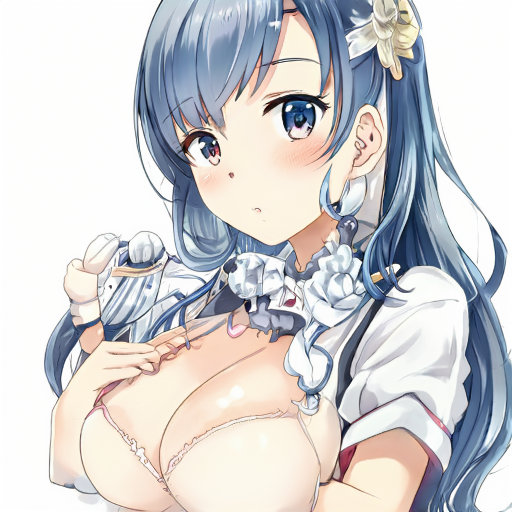

In [36]:
create_im(torch.from_numpy(output_syn[0]),"banglas.jpg")

In [26]:
import pickle
deepdanbooru_dirs = pickle.load(open(r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\deepdanbooru_dirs.pkl", 'rb'))
named_directions = {}
latent_dirs = []
starts = []
ends = []

comp = 0
for tag, vec in deepdanbooru_dirs.items():
    print(tag)
    for layers in [(0, 6), (6, 12), (12, 16)]:
        print(layers[0], layers[1])
        name = tag + "-" + str(layers[0]) + "-" + str(layers[1])
        named_directions[f'{name}'] = [comp, int(layers[0]), int(layers[1]), f'{name}']
    latent_dirs.append(np.matrix(vec[0]))
    comp = comp + 1
print(comp)
    #if comp > 50:
    #    break
#named_directions


1boy
0 6
6 12
12 16
1girl
0 6
6 12
12 16
2boys
0 6
6 12
12 16
2girls
0 6
6 12
12 16
3girls
0 6
6 12
12 16
:d
0 6
6 12
12 16
^_^
0 6
6 12
12 16
ahoge
0 6
6 12
12 16
alternate_costume
0 6
6 12
12 16
animal_ears
0 6
6 12
12 16
apron
0 6
6 12
12 16
aqua_eyes
0 6
6 12
12 16
aqua_hair
0 6
6 12
12 16
armor
0 6
6 12
12 16
armpits
0 6
6 12
12 16
arms_behind_back
0 6
6 12
12 16
arms_up
0 6
6 12
12 16
ass
0 6
6 12
12 16
bag
0 6
6 12
12 16
bandages
0 6
6 12
12 16
bangs
0 6
6 12
12 16
bare_shoulders
0 6
6 12
12 16
barefoot
0 6
6 12
12 16
belt
0 6
6 12
12 16
bikini
0 6
6 12
12 16
black_background
0 6
6 12
12 16
black_dress
0 6
6 12
12 16
black_eyes
0 6
6 12
12 16
black_hair
0 6
6 12
12 16
black_legwear
0 6
6 12
12 16
black_skirt
0 6
6 12
12 16
blonde_hair
0 6
6 12
12 16
blue_background
0 6
6 12
12 16
blue_dress
0 6
6 12
12 16
blue_eyes
0 6
6 12
12 16
blue_hair
0 6
6 12
12 16
blue_skirt
0 6
6 12
12 16
blue_sky
0 6
6 12
12 16
blue_theme
0 6
6 12
12 16
blunt_bangs
0 6
6 12
12 16
blurry
0 6
6 12
12 16
b

In [24]:
for i, item in enumerate(named_directions):
    name = named_directions[item][3]
    print(name)

1boy-0-6
1boy-6-12
1boy-12-16
1girl-0-6
1girl-6-12
1girl-12-16
2boys-0-6
2boys-6-12
2boys-12-16
2girls-0-6
2girls-6-12
2girls-12-16
3girls-0-6
3girls-6-12
3girls-12-16
:d-0-6
:d-6-12
:d-12-16
^_^-0-6
^_^-6-12
^_^-12-16
ahoge-0-6
ahoge-6-12
ahoge-12-16
alternate_costume-0-6
alternate_costume-6-12
alternate_costume-12-16
animal_ears-0-6
animal_ears-6-12
animal_ears-12-16
apron-0-6
apron-6-12
apron-12-16
aqua_eyes-0-6
aqua_eyes-6-12
aqua_eyes-12-16
aqua_hair-0-6
aqua_hair-6-12
aqua_hair-12-16
armor-0-6
armor-6-12
armor-12-16
armpits-0-6
armpits-6-12
armpits-12-16
arms_behind_back-0-6
arms_behind_back-6-12
arms_behind_back-12-16
arms_up-0-6
arms_up-6-12
arms_up-12-16
ass-0-6
ass-6-12
ass-12-16
bag-0-6
bag-6-12
bag-12-16
bandages-0-6
bandages-6-12
bandages-12-16
bangs-0-6
bangs-6-12
bangs-12-16
bare_shoulders-0-6
bare_shoulders-6-12
bare_shoulders-12-16
barefoot-0-6
barefoot-6-12
barefoot-12-16
belt-0-6
belt-6-12
belt-12-16
bikini-0-6
bikini-6-12
bikini-12-16
black_background-0-6
black_back

In [18]:
# import os
# named_directions = {}
# latent_dirs = []
# starts = []
# ends = []
# # 
# path_to_directions = r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\tadne-directions"

# # This loads the directions in a dictionary in this format:
# # {'name' : [direction_num, start, end]}
# # and you load the direction by:
# # directions[direction_num]

# for i,file in enumerate(sorted(os.listdir(path_to_directions))):
#     np_file = np.load(f'{path_to_directions}/{file}', allow_pickle=True)
#     name = file.split("_layers_")[0].split("/")[-1]
#     file = file.split('_')
#     comp = int(name.split(".")[0][1:])
    
#     named_directions[f'{name}'] = [comp, int(file[-2]), int(file[-1].split('.')[0]), f'{name}']
#     if int(file[-2]) == 0:
#         latent_dirs.append(np_file)

In [ ]:
# print(named_directions)
# print(latent_dirs)
# print(len(named_directions))

In [17]:
len(named_directions)

828

In [11]:
#Dump Named_directions to json
import json
with open(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\named_directions.json', 'w') as outfile:
    json.dump(named_directions, outfile)

In [8]:
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)

# jsons = json.dumps(latent_dirs, cls=NumpyEncoder)

# with open(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\latent_dirs.json', 'w') as outfile:
#     json.dump(jsons, outfile)

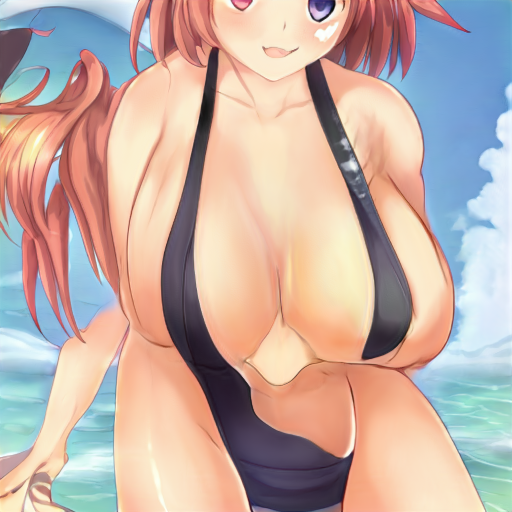

In [13]:
import numpy as np
def normalize(v):
    norm=np.linalg.norm(v, ord=2)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm * len(v)

latent_dirs_dict = {}
n_sample = 1
inputSize = 1024
input_size = 1024
truncation = 0.5
seed = 26225
#seed = 93940
#seed = 0 
scale = 1
latent_avg = np.zeros(shape=(1024,),dtype=np.float32)
z = np.random.RandomState(seed).randn(n_sample, inputSize).astype("float32")
all_W = ort_sess_MAP.run(None, {'rand_array': z})[0]

for i, tag in enumerate(named_directions):
    values = named_directions[tag]
    value = 0.0
    string = "bikini-0-6"
    if string in values:
        value = 21
        #value = 3
    # elif 'breasts-0-6' in values:
    #     value = 1.8
    # elif 'breasts-6-12' in values:
    #     value = 2.6
    start_l = named_directions[tag][1]
    end_l = min(16, named_directions[tag][2])
    direction_l = normalize(latent_dirs[named_directions[tag][0]])
    latent_dirs_dict[tag] = direction_l.tolist()
    

    for l in range(start_l, end_l):
        all_W[0][l] = all_W[0][l] + direction_l * value * scale

if truncation != 1:
    w_avg = latent_avg
    all_W = w_avg + (all_W - w_avg) * truncation # [minibatch, layer, component]

img = ort_sess_SYNTH.run(None, {'latent_w': all_W})
import torch, PIL.Image
create_im(torch.from_numpy(img[0]),"banglasv2.jpg")

In [14]:
with open(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\latent_dirs_dict.json', 'w') as outfile:
    json.dump(latent_dirs_dict, outfile)

In [15]:
import json
rs = r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\named_directions.json'
with open(rs) as json_file:
    named_directions = json.load(json_file)

rs = r"C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\latent_dirs_dict.json"
with open(rs) as json_file:
    latent_dirs_dict = json.load(json_file)


In [16]:
named_latents = {}
for k,v in named_directions.items():
    named_latents[k] = []
    tmp = named_directions[k]
    named_latents[k].append(tmp)
    named_latents[k].append(latent_dirs_dict[k])
    

In [17]:
with open(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\named_latents.json', 'w') as outfile:
    json.dump(named_latents, outfile)

[0, 0, 6, '1boy-0-6']
[0, 6, 12, '1boy-6-12']
[0, 12, 16, '1boy-12-16']
[1, 0, 6, '1girl-0-6']
[1, 6, 12, '1girl-6-12']
[1, 12, 16, '1girl-12-16']
[2, 0, 6, '2boys-0-6']
[2, 6, 12, '2boys-6-12']
[2, 12, 16, '2boys-12-16']
[3, 0, 6, '2girls-0-6']
[3, 6, 12, '2girls-6-12']
[3, 12, 16, '2girls-12-16']
[4, 0, 6, '3girls-0-6']
[4, 6, 12, '3girls-6-12']
[4, 12, 16, '3girls-12-16']
[5, 0, 6, ':d-0-6']
[5, 6, 12, ':d-6-12']
[5, 12, 16, ':d-12-16']
[6, 0, 6, '^_^-0-6']
[6, 6, 12, '^_^-6-12']
[6, 12, 16, '^_^-12-16']
[7, 0, 6, 'ahoge-0-6']
[7, 6, 12, 'ahoge-6-12']
[7, 12, 16, 'ahoge-12-16']
[8, 0, 6, 'alternate_costume-0-6']
[8, 6, 12, 'alternate_costume-6-12']
[8, 12, 16, 'alternate_costume-12-16']
[9, 0, 6, 'animal_ears-0-6']
[9, 6, 12, 'animal_ears-6-12']
[9, 12, 16, 'animal_ears-12-16']
[10, 0, 6, 'apron-0-6']
[10, 6, 12, 'apron-6-12']
[10, 12, 16, 'apron-12-16']
[11, 0, 6, 'aqua_eyes-0-6']
[11, 6, 12, 'aqua_eyes-6-12']
[11, 12, 16, 'aqua_eyes-12-16']
[12, 0, 6, 'aqua_hair-0-6']
[12, 6, 12, 

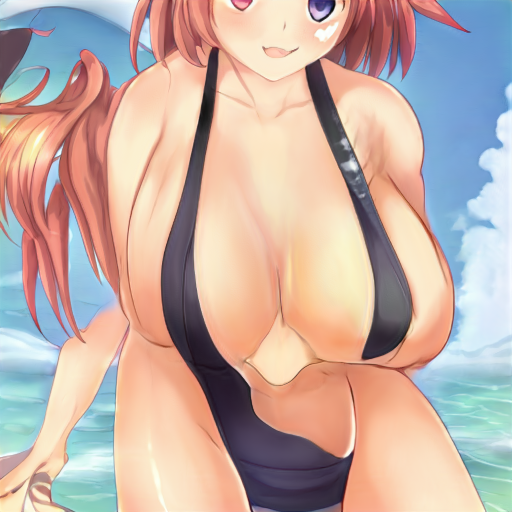

In [25]:
import numpy as np


n_sample = 1
inputSize = 1024
input_size = 1024
truncation = 0.5
seed = 26225
#seed = 93940
#seed = 0 
scale = 1
latent_avg = np.zeros(shape=(1024,),dtype=np.float32)
z = np.random.RandomState(seed).randn(n_sample, inputSize).astype("float32")
all_W = ort_sess_MAP.run(None, {'rand_array': z})[0]

for i, tag in enumerate(named_directions):
    values = named_directions[tag]
    print(values)
    value = 0.0
    string = "bikini-0-6"
    if string in values:
        value = 21
        #value = 3
    # elif 'breasts-0-6' in values:
    #     value = 1.8
    # elif 'breasts-6-12' in values:
    #     value = 2.6
    start_l = named_directions[tag][1]
    end_l = min(16, named_directions[tag][2])
    direction_l = np.asarray(latent_dirs_dict[tag],dtype=np.float32)
    #latent_dirs_dict[tag] = direction_l
    

    for l in range(start_l, end_l):
        all_W[0][l] = all_W[0][l] + direction_l * value * scale

if truncation != 1:
    w_avg = latent_avg
    all_W = w_avg + (all_W - w_avg) * truncation # [minibatch, layer, component]

img = ort_sess_SYNTH.run(None, {'latent_w': all_W})
import torch, PIL.Image
create_im(torch.from_numpy(img[0]),"banglasv2.jpg")

In [ ]:
print(named_latents)

In [4]:
import json
with open(r'C:\Users\Aravind\OneDrive - Nanyang Technological University\FYP\FYP Anime GAN Implementations\TADNE\Torch\StyleGAN2-ADA and StyleGAN3 TADNE\stylegan2-ada-pytorch\pkl_files\named_latents.json') as outfile:
    named_latents = json.load(outfile)

In [53]:
import numpy as np
from collections import deque
import torch, PIL.Image
# {'1boy-0-6': [[0, 0, 6, '1boy-0-6'], [[-0.05350423792654828..]] ]}
# seed = 26225
#seed = 93940
#seed = 0 
#[("1boy-0-6",val)]

def TADNEdit(named_latents, n_sample: int = 1, listedit = [], seed = 0, scale = 1):
    queue = deque(listedit)
    n_sample = 1
    inputSize = 1024
    truncation = 0.5
    scale = 1
    latent_avg = np.zeros(shape=(1024,),dtype=np.float32)
    z = np.random.RandomState(seed).randn(n_sample, inputSize).astype("float32")

    all_W = ort_sess_MAP.run(None, {'rand_array': z})[0]

    while queue:
        try:
            key, value = queue.popleft()
            print(f"Key: {key} was processed")
            
        except Exception as e:
            print(f"Key: {key} was NOT processed")
            print(e)

        if key in named_latents and (value != 0 and value != 0.0):
            named_directions = named_latents[key][0]
            start_l = named_directions[1]
            end_l = min(16, named_directions[2])
            direction_l = np.asarray(named_latents[key][1],dtype=np.float32)
        
            for l in range(start_l, end_l):
                all_W[0][l] = all_W[0][l] + direction_l * value * scale
        
        else: print(f"KEY: {key} not found in Dictionary Latens")
    
    if truncation != 1:
        w_avg = latent_avg
        all_W = w_avg + (all_W - w_avg) * truncation # [minibatch, layer, component]

    img = ort_sess_SYNTH.run(None, {'latent_w': all_W})[0].astype('float32')
    img = np.interp(img, (img.min(), img.max()), (0, 255))
    imgs = np.asarray(np.clip(np.transpose(img, (0,2,3,1)),0,255),dtype=np.uint8)[0]
    return PIL.Image.fromarray(imgs,"RGB")

Key: bikini-0-6 was processed
Key: bikini-6-12 was processed


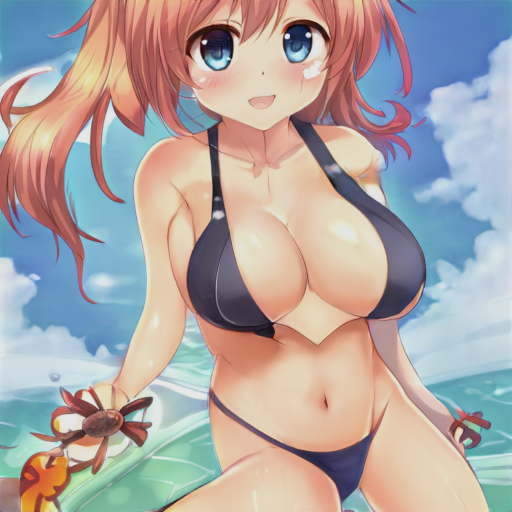

In [54]:
TADNEdit(named_latents=named_latents,listedit=[("bikini-0-6",5.9),("bikini-6-12",5.9)],seed=26225)

Key: bikini-0-6 was processed
Key: bikini-6-12 was processed


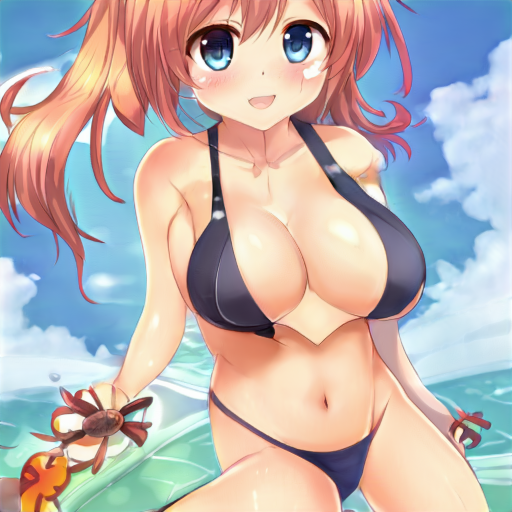

In [14]:
TADNEdit(named_latents=named_latents,listedit=[("bikini-0-6",5.9),("bikini-6-12",5.9)],seed=26225)

#### CLIP MODEL

In [ ]:
# import torch
# from onnxruntime.training.experimental import export_gradient_graph

# # We need a custom loss function to load the graph in an InferenceSession in ONNX Runtime Web.
# # You can still make the gradient graph with torch.nn.CrossEntropyLoss() and this part will work but you'll get problem later when trying to use the graph in JavaScript.
# def binary_cross_entropy_loss(output, target):
#     return -torch.sum(target * torch.log2(output[:, 0]) +
#         (1-target) * torch.log2(output[:, 1]))


# loss_fn = binary_cross_entropy_loss

# input_size = 10
# num_classes = 2
# model = MyModel(input_size=input_size, hidden_size=5, num_classes=num_classes)

# # File path for where to save the ONNX graph.
# gradient_graph_path = 'gradient_graph.onnx'

# # We need example input for the ONNX model.
# # It doesn't matter what values are filled in the but the dimensions need to be correct.
# batch_size = 32
# example_input = torch.randn(
#     batch_size, input_size, requires_grad=True)
# example_labels = torch.randint(0, num_classes, (batch_size,))

# export_gradient_graph(
#     model, loss_fn, example_input, example_labels, gradient_graph_path)

In [59]:

import clip
import torch
import open_clip
#from functools import partial
from copy import deepcopy

m, _, pre = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16', device="cpu")
m.eval()

m2 = deepcopy(m)
m2.forward = lambda text: m2.encode_text(text)
m2.eval()

dummy_texts = clip.tokenize(["quick brown fox", "lorem ipsum", "a"]).cpu()
print(dummy_texts.size())
print("Actual TEXT: ",m2(dummy_texts))


torch.onnx.export(m2, (dummy_texts), "clip_resnet.onnx", export_params=True,
  input_names=["TEXT"],
  output_names=["ENCODED_TEXT"],
  opset_version=16,
  dynamic_axes={
      "TEXT": {
          0: "text_batch_size",
      },
      "ENCODED_TEXT": {
        0: "text_batch_size"
      }
  }
)


# Now run onnxruntime to verify
import onnxruntime as ort

ort_sess = ort.InferenceSession("clip_resnet.onnx")
result=ort_sess.run(None, {"TEXT": dummy_texts.numpy()})
print(result[0].shape)
print(result) # verify that result is comparable to (1)

torch.Size([3, 77])
Actual TEXT:  tensor([[-0.2809,  0.1179, -0.1051,  ...,  0.1799,  0.1038,  0.2099],
        [-0.1205,  0.0345,  0.2030,  ...,  0.1493,  0.1189, -0.1469],
        [-0.2589,  0.3277, -0.1015,  ..., -0.0647, -0.6207, -0.1159]],
       grad_fn=<MmBackward0>)


c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\torch\onnx\symbolic_opset9.py:4207: UserWarning: Exporting aten::index operator of advanced indexing in opset 16 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  + "If indices include negative values, the exported graph will produce incorrect results."


(3, 512)
[array([[-0.2808801 ,  0.11789356, -0.10507709, ...,  0.17994633,
         0.10380451,  0.20988931],
       [-0.1204724 ,  0.034467  ,  0.2030372 , ...,  0.14925496,
         0.11889322, -0.14690429],
       [-0.2589423 ,  0.32769528, -0.10148081, ..., -0.06471331,
        -0.62072617, -0.11593563]], dtype=float32)]


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [11]:

import clip
import torch
import open_clip
#from functools import partial
from copy import deepcopy

torch.cuda.set_device(0)
device = "gpu"
m, _, pre = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16', device='cuda')
m.eval()

dummy_image = torch.randn(10, 3, 224, 224).cuda()
m2 = deepcopy(m)
m2.cuda()
m2.forward = lambda text: m2.encode_image(dummy_image)
m2.eval()

dummy_texts = clip.tokenize(["quick brown fox", "lorem ipsum"]).cuda()
print("Actual TEXT: ",m2(dummy_image))


torch.onnx.export(m2, (dummy_image), "clip_resnet.onnx", export_params=True,
  input_names=["IMAGE"],
  output_names=["ENCODED_IMAGE"],
  opset_version=16,
  dynamic_axes={
      "IMAGE": {
          0: "image_batch_size",
      },
      "ENCODED_IMAGE" : {
        0 : 'image_batch_size'
      }
  }
)


# Now run onnxruntime to verify
import onnxruntime as ort

ort_sess = ort.InferenceSession("clip_resnet.onnx")
result=ort_sess.run(None, {"IMAGE": dummy_image.cpu().numpy()})
print(result) # verify that result is comparable to (1)

Actual TEXT:  tensor([[-0.2215,  0.3791,  0.2078,  ..., -0.4508, -0.0838, -0.3283],
        [-0.1987,  0.4441,  0.1445,  ..., -0.5536, -0.1148, -0.3570],
        [-0.1940,  0.4226,  0.1881,  ..., -0.5107, -0.0350, -0.4153],
        ...,
        [-0.2371,  0.4406,  0.0871,  ..., -0.4891, -0.1179, -0.3212],
        [-0.2170,  0.4225,  0.1642,  ..., -0.4877, -0.0390, -0.3775],
        [-0.2129,  0.3916,  0.1737,  ..., -0.5404, -0.0259, -0.4148]],
       device='cuda:0', grad_fn=<MmBackward0>)
[array([[-0.22147867,  0.37910396,  0.20776604, ..., -0.45080584,
        -0.08381216, -0.32827592],
       [-0.1987006 ,  0.4441138 ,  0.14450622, ..., -0.5536358 ,
        -0.11479089, -0.3570315 ],
       [-0.1939841 ,  0.4226316 ,  0.1880754 , ..., -0.51066923,
        -0.03501027, -0.41526896],
       ...,
       [-0.23708418,  0.4406153 ,  0.08706559, ..., -0.48905548,
        -0.11785711, -0.32123798],
       [-0.21698813,  0.422545  ,  0.16417336, ..., -0.4876877 ,
        -0.03899603, -0.377

In [ ]:
# Now run onnxruntime to verify
import onnxruntime as ort

ort_sess = ort.InferenceSession("clip_resnet.onnx")
result=ort_sess.run(input_feed={"TEXT": dummy_texts.numpy()},output_names="S")
print(result) # verify that result is comparable to (1)

In [33]:


import clip
import torch

m, _, pre = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16', device="cpu")
npx = 224
dummy_image = torch.randn(10, 3, npx, npx).cpu()
dummy_texts = clip.tokenize(["quick brown fox", "lorem ipsum"]).cpu()
print(m(dummy_image,dummy_texts)) # Original CLIP result (1)

torch.onnx.export(m, (dummy_image, dummy_texts), "clip_resnet.onnx", export_params=True,
  input_names=["IMAGE", "TEXT"],
  output_names=["LOGITS_PER_IMAGE", "LOGITS_PER_TEXT","SANLGA"],
  opset_version=14,
  dynamic_axes={
      "IMAGE": {
          0: "image_batch_size",
      },
      "TEXT": {
          0: "text_batch_size",
      },
      "LOGITS_PER_IMAGE": {
          0: "image_batch_size",
          1: "text_batch_size",
      },
      "LOGITS_PER_TEXT": {
          0: "text_batch_size",
          1: "image_batch_size",
      },
  }
)

# Now run onnxruntime to verify
import onnxruntime as ort

ort_sess = ort.InferenceSession("clip_resnet.onnx")
result=ort_sess.run(["LOGITS_PER_IMAGE", "LOGITS_PER_TEXT"], 
  {"IMAGE": dummy_image.numpy(), "TEXT": dummy_texts.numpy()})
print(result) # verify that result is comparable to (1)

(tensor([[-0.0273,  0.0413,  0.0185,  ..., -0.0568, -0.0121, -0.0375],
        [-0.0260,  0.0374,  0.0074,  ..., -0.0477, -0.0125, -0.0418],
        [-0.0279,  0.0368,  0.0128,  ..., -0.0461, -0.0113, -0.0374],
        ...,
        [-0.0281,  0.0378,  0.0125,  ..., -0.0500, -0.0084, -0.0243],
        [-0.0198,  0.0403,  0.0214,  ..., -0.0479, -0.0102, -0.0424],
        [-0.0171,  0.0409,  0.0174,  ..., -0.0460, -0.0071, -0.0437]],
       grad_fn=<DivBackward0>), tensor([[-0.0437,  0.0183, -0.0164,  ...,  0.0280,  0.0162,  0.0327],
        [-0.0174,  0.0050,  0.0294,  ...,  0.0216,  0.0172, -0.0212]],
       grad_fn=<DivBackward0>), tensor(100.0000, grad_fn=<ExpBackward0>))
[array([[-0.02726337,  0.04131971,  0.01852497, ..., -0.05677447,
        -0.01210024, -0.03753503],
       [-0.02601652,  0.03736527,  0.00743642, ..., -0.04765632,
        -0.01251964, -0.04181425],
       [-0.02786271,  0.0367972 ,  0.01276983, ..., -0.04608851,
        -0.01126718, -0.03738111],
       ...,
     

In [28]:
! pip install onnx onnxruntime

import clip
import torch

m, pre = clip.load("ViT-B/32",device='cpu')
npx = m.visual.input_resolution
dummy_image = torch.randn(10, 3, npx, npx).cpu()
dummy_texts = clip.tokenize(["quick brown fox", "lorem ipsum"]).cpu()
m.forward(dummy_image,dummy_texts) # Original CLIP result (1)

torch.onnx.export(m, (dummy_image, dummy_texts), "clip_resnet.onnx", export_params=True,
  input_names=["IMAGE", "TEXT"],
  output_names=["LOGITS_PER_IMAGE", "LOGITS_PER_TEXT"],
  opset_version=14,
  dynamic_axes={
      "IMAGE": {
          0: "image_batch_size",
      },
      "TEXT": {
          0: "text_batch_size",
      },
      "LOGITS_PER_IMAGE": {
          0: "image_batch_size",
          1: "text_batch_size",
      },
      "LOGITS_PER_TEXT": {
          0: "text_batch_size",
          1: "image_batch_size",
      },
  }
)

# Now run onnxruntime to verify
import onnxruntime as ort

ort_sess = ort.InferenceSession("clip_resnet.onnx")
result=ort_sess.run(["LOGITS_PER_IMAGE", "LOGITS_PER_TEXT"], 
  {"IMAGE": dummy_image.numpy(), "TEXT": dummy_texts.numpy()})
result # verify that result is comparable to (1)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


c:\Users\Aravind\anaconda3\envs\lit\lib\site-packages\torch\onnx\symbolic_opset9.py:4207: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  + "If indices include negative values, the exported graph will produce incorrect results."


[array([[19.31246 , 24.99552 ],
        [19.204832, 24.729586],
        [19.608593, 24.874842],
        [19.446264, 24.45345 ],
        [20.11337 , 24.601547],
        [19.803015, 24.467579],
        [19.413633, 24.637894],
        [20.033848, 24.380203],
        [19.760288, 24.779083],
        [19.443174, 24.548098]], dtype=float32),
 array([[19.31246 , 19.204832, 19.608593, 19.446264, 20.11337 , 19.803015,
         19.413633, 20.033848, 19.760288, 19.443174],
        [24.99552 , 24.729586, 24.874842, 24.45345 , 24.601547, 24.467579,
         24.637894, 24.380203, 24.779083, 24.548098]], dtype=float32)]